# USCOTS 2019 Block 3 - Advanced Data Management with dplyr

Students need time and practice to learn how to best to utilize the data wrangling verbs.  The exercise presented here will put into practice many verbs including:  

* Filter
* Select
* Mutate
* Gather / Spread
* Join

## Goal: Investigate the proportion women & men ages 19-34 who do not have health insurance.  

This exercise will use data obtained from the Census Bureau's American Community Survey [Link](https://www.census.gov/programs-surveys/acs).  Information from the American Community Survey 5-Year Estimates (ACS5) will be obtained for this exercise.  This investigation will require information about number of females / males in the desired age categories, the number of females / males without health insurance.  Information regarding per capita income will be obtained as well.


* Population: Female / Male, Ages 18 - 34 [ACS5 Link](https://api.census.gov/data/2017/acs/acs5?get=B01001_007E,B01001_008E,B01001_009E,B01001_010E,B01001_011E,B01001_012E,B01001_031E,B01001_032E,B01001_033E,B01001_034E,B01001_035E,B01001_036E&for=county:*&for=state:*)
    * Males: B01001_007E - B01001_012E
    * Females: B01001_031E - B01001_036E
* Not Insured: Female / Malne, Ages 19-34 [ACS5 Link](https://api.census.gov/data/2017/acs/acs5?get=B27001_011E,B27001_014E,B27001_039E,B27001_042E&for=county:*&for=state:*)
    * Males: B27001_011E, B27001_014E
    * Females: B27001_039E, B27001_042E
* (Median) Per Capita Income [ACS5 Link](https://api.census.gov/data/2017/acs/acs5?get=B19301_001E&for=county:*&for=state:*)
    * B19301_001E


## Guiding Questions
1. What counties have the highest proportion of individuals without health insurance for ages 19-34?
2. What counties have the highest proportion of females without health insurance for ages 19-34?
3. Are the counties identified above for females the same as those for males?  Briefly discuss.



## Loading the required packages in R
This excerise will require the following packages / libraries in R.  The library() command will load this packages.

In [111]:
#Load tidyr, dplyr, and readr libraries
library(tidyr)
library(dplyr)
library(readr)

## Reading in the four datasets from the American Community Survey API
1. ACS5_Name: Identifies the names of the counties and their associated FIPS code
2. ACS5_Income: Dataset that contains median per capita income
3. ACS5_NoInsurance: Dataset that contains a count of the number of females and males without health insurance in the desired age range
4. ACS5_Population: Dataset that contains population counts for the desired age range

In [112]:
ACS5_Names <- read_csv("C:/Users/aq7839yd/Desktop/USCOTS 2019/Workshop/Block3/Reshape/ACS5_Names.csv", col_types = cols())
ACS5_Income <- read_csv("C:/Users/aq7839yd/Desktop/USCOTS 2019/Workshop/Block3/Reshape/ACS5_Income.csv", col_types = cols())
ACS5_NoInsurance <- read_csv("C:/Users/aq7839yd/Desktop/USCOTS 2019/Workshop/Block3/Reshape/ACS5_NoInsurance.csv", col_types = cols())
ACS5_Population <- read_csv("C:/Users/aq7839yd/Desktop/USCOTS 2019/Workshop/Block3/Reshape/ACS5_Population.csv", col_types = cols())


The following provides a snipit of the initial population table provided by the ACS5 API.  The variable names were edited as shown.  The desired table is provided as well.  The code below will produce this table.

## Initial Population Table
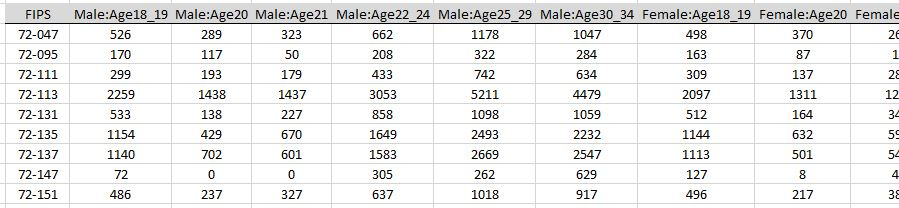

## Desired Table for Population

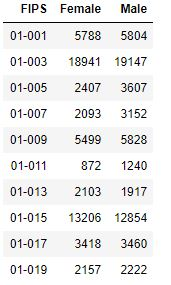

The followning code will produce the desired population table.  Sequentially remove the \# from the beginning of each line and run the code in this cell after each removal.  

### Questions
1. What is the purpose of the gather() function?
2. What does separate() do?
3. Why must separate() be used before group_by() and summarise()?
4. Verify the calculation being done by summarise() for at least one FIPS code.


In [113]:
#Data Managament for Population Table
(ACS5_Population
  %>% gather(key="Gender:Age", value="Count", 2:13)
  %>% separate(`Gender:Age`,c("Gender","Age"), sep=":")
  %>% group_by(FIPS,Gender)
  %>% summarise('N'=sum(Count))
  %>% spread(key="Gender", value='N')
  #%>% head(10)
) -> ACS5_Population_F_and_M
#Printing first few lines of table produced
head(ACS5_Population_F_and_M)

FIPS,Female,Male
01-001,5788,5804
01-003,18941,19147
01-005,2407,3607
01-007,2093,3152
01-009,5499,5828
01-011,872,1240


## Working with the NoInsurance Table

The following code produces the desired outcome for the NoInsurance table.

In [114]:
#Data Managament for NoInsurance Table
(ACS5_NoInsurance
  %>% gather(key="Gender:Age", value="Count", 2:5)
  %>% separate(`Gender:Age`,c("Gender","Age"),sep=":")
  %>% group_by(FIPS,Gender)
  %>% summarise('N'=sum(Count))
  %>% spread(key="Gender", value='N')
  #%>% head(10)
) -> ACS5_NoInsurance_F_and_M
#Printing first few lines of table produced
head(ACS5_NoInsurance_F_and_M)

FIPS,Female,Male
01-001,1018,918
01-003,3607,4863
01-005,494,754
01-007,272,307
01-009,978,1248
01-011,278,410


# JOIN: Joining the Four Tables

The following tables will be joined together.  The primary key being used for the join is FIPS.
* ACS5_Population_F_and_M
* ACS5_NoInsurance_F_and_M
* ACS5_Income (original data read in above)
* ACS5_Names (original data read in above)

The rename() function will be used to provide viable columns names for the new table.

In [115]:
#Join Population, NoInsurance, Income, and Names
(ACS5_Population_F_and_M
  %>% left_join(ACS5_NoInsurance_F_and_M,by="FIPS")
  %>% left_join(ACS5_Income,by="FIPS")
  %>% left_join(ACS5_Names,by="FIPS")
  %>% rename("Pop_Female"=Female.x,"Pop_Male"=Male.x,"NoIns_Female"=Female.y,"NoIns_Male"=Male.y)
) -> ACS5_Population_NoInsurance_Income


# Computing the \% No Insurance by Gender

The proportion of individuals, the proportion of females, and the proportion of males that have no health insurance needs to be computed.  The mutate() function will be used to do these calculations.

$NoIns\_Percent = \frac{NoIns\_Female + NoIns\_Male}{Pop\_Female + Pop\_Male}$

$Female\_NoIns\_Percent = \frac{NoIns\_Female}{Pop\_Female}$

$Male\_NoIns\_Percent = \frac{NoIns\_Male}{Pop\_Male}$





In [116]:
#Compute perentage NoInsurance for Females and Males
(ACS5_Population_NoInsurance_Income
  %>%mutate("Female_NoIns_Percent"=round(NoIns_Female/Pop_Female, 3),"Male_NoIns_Percent"=round(NoIns_Male/Pop_Male,3), "NoIns_Percent" = round(((NoIns_Female+NoIns_Male)/(Pop_Female+Pop_Male)),3))
) -> ACS5_Population_NoInsurance_Income_Percents


# Getting Top 10 Counties

In [117]:
#Get top 10 list, based on invdividuals with no health insurance
(ACS5_Population_NoInsurance_Income_Percents
  %>%arrange(desc(NoIns_Percent))
  %>%select(FIPS,NAME,NoIns_Percent)
  %>%head(10)  
) -> OutputTable_Top10
#Print the table to the screen
OutputTable_Top10


FIPS,NAME,NoIns_Percent
48-261,"Kenedy County, Texas",0.667
46-017,"Buffalo County, South Dakota",0.653
48-327,"Menard County, Texas",0.628
48-505,"Zapata County, Texas",0.605
46-095,"Mellette County, South Dakota",0.601
02-013,"Aleutians East Borough, Alaska",0.578
30-035,"Glacier County, Montana",0.572
41-055,"Sherman County, Oregon",0.567
46-121,"Todd County, South Dakota",0.565
30-003,"Big Horn County, Montana",0.564


# Getting Top 10 Counties for Females

In [118]:
#Get top 25 list, based on Female NoInsurance
(ACS5_Population_NoInsurance_Income_Percents
  %>%arrange(desc(Female_NoIns_Percent))
  %>%select(FIPS,NAME,Female_NoIns_Percent)
  %>%head(10)
) -> OutputTable_Top10_Females
#Print the table to the screen
OutputTable_Top10_Females

FIPS,NAME,Female_NoIns_Percent
32-009,"Esmeralda County, Nevada",0.709
46-017,"Buffalo County, South Dakota",0.616
48-505,"Zapata County, Texas",0.594
02-013,"Aleutians East Borough, Alaska",0.553
48-383,"Reagan County, Texas",0.549
48-191,"Hall County, Texas",0.548
13-309,"Wheeler County, Georgia",0.545
30-035,"Glacier County, Montana",0.545
48-385,"Real County, Texas",0.534
48-083,"Coleman County, Texas",0.528


# Getting Top 10 Counties for Males

In [119]:
#Get top 25 list, based on Female NoInsurance
(ACS5_Population_NoInsurance_Income_Percents
  %>%arrange(desc(Male_NoIns_Percent))
  %>%select(FIPS,NAME,Male_NoIns_Percent)
  %>%head(10)
) -> OutputTable_Top10_Males
#Print the table to the screen
OutputTable_Top10_Males

FIPS,NAME,Male_NoIns_Percent
48-261,"Kenedy County, Texas",0.895
48-269,"King County, Texas",0.736
48-327,"Menard County, Texas",0.725
46-095,"Mellette County, South Dakota",0.722
46-017,"Buffalo County, South Dakota",0.693
46-102,"Oglala Lakota County, South Dakota",0.681
46-121,"Todd County, South Dakota",0.664
13-061,"Clay County, Georgia",0.652
46-041,"Dewey County, South Dakota",0.652
41-055,"Sherman County, Oregon",0.643


## Questions
1. How much overlap is there between the Top 10 list for Females and Males?  Briefly discuss.
2. Some counties may suffer from small population counts.  Apply a reasonable filter to the code above to exclude such counties from their respective Top 10 lists.
3. Suppose a Top 100 list was obtained instead of a Top 10 list.  Which state has the most counties in this Top 100 list?

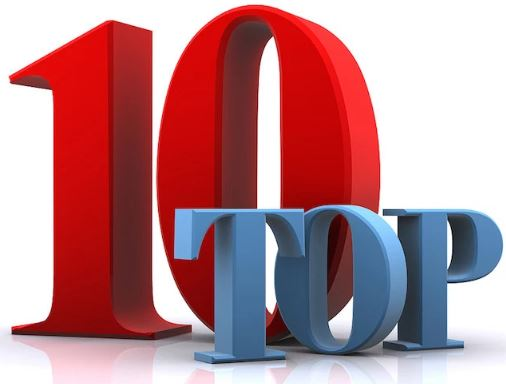